In [3]:
import pandas as pd

df = pd.read_csv('data/Consumo_cerveja.csv', 
                 decimal=',', 
                 thousands='.', 
                 header=0, 
                 names=['date','median_temp','min_temp','max_temp','precip','weekend','consumption'], 
                 parse_dates=['date'], 
                 nrows=365)

# Groupby

Grouping by weekend

In [163]:
grouper = df.groupby('weekend')

In [164]:
grouper

In [165]:
grouper.size()

weekend
0    261
1    104
dtype: int64

In [166]:
grouper.mean()

,median_temp,min_temp,max_temp,precip,consumption
weekend,,,,,
0,21.328199,17.567433,26.721073,5.184291,23998.222222
1,20.970769,17.195192,26.336538,5.227885,28922.721154


In [167]:
grouper.groups

{0: Int64Index([  0,   1,   4,   5,   6,   7,   8,  11,  12,  13,
             ...
             351, 354, 355, 356, 357, 358, 361, 362, 363, 364],
            dtype='int64', length=261),
 1: Int64Index([  2,   3,   9,  10,  16,  17,  23,  24,  30,  31,
             ...
             331, 332, 338, 339, 345, 346, 352, 353, 359, 360],
            dtype='int64', length=104)}

In [168]:
grouper.consumption.sum()

weekend
0    6263536
1    3007963
Name: consumption, dtype: int64

In [170]:
grouper.get_group(1)

,date,median_temp,min_temp,max_temp,precip,weekend,consumption
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799
9,2015-01-10,26.76,22.1,34.2,0.0,1,37937
10,2015-01-11,27.62,22.2,34.8,3.4,1,36254
16,2015-01-17,28.86,22.0,35.8,0.0,1,37690
17,2015-01-18,28.26,23.4,35.6,0.0,1,30524
23,2015-01-24,23.12,19.0,29.4,13.0,1,28348
24,2015-01-25,24.40,18.1,30.0,0.0,1,31088
30,2015-01-31,21.64,18.5,24.3,0.2,1,27030
31,2015-02-01,24.16,20.6,28.0,0.0,1,32057


In [173]:
grouper.agg(['std', 'mean'])

median_temp             min_temp             max_temp             \
                std       mean       std       mean       std       mean   
weekend                                                                    
0          3.165052  21.328199  2.765010  17.567433  4.292047  26.721073   
1          3.218723  20.970769  2.971234  17.195192  4.389087  26.336538   

            precip            consumption                
               std      mean          std          mean  
weekend                                                  
0        12.068447  5.184291  3787.526525  23998.222222  
1        13.315211  5.227885  3830.190843  28922.721154

In [174]:
grouper.agg({'median_temp': ['std', 'mean'], 
             'consumption': 'sum'})

median_temp            consumption
                std       mean         sum
weekend                                   
0          3.165052  21.328199     6263536
1          3.218723  20.970769     3007963

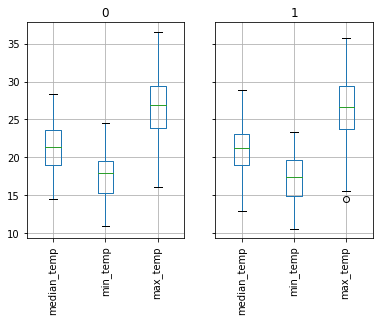

In [187]:
grouper.boxplot(rot=90, column=['median_temp', 'min_temp', 'max_temp']);

# Resample

In [6]:
df = df.set_index('date')

In [7]:
df.head()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-01,27.30,23.9,32.5,0.0,0,25461
2015-01-02,27.02,24.5,33.5,0.0,0,28972
2015-01-03,24.82,22.4,29.9,0.0,1,30814
2015-01-04,23.98,21.5,28.6,1.2,1,29799
2015-01-05,23.82,21.0,28.3,0.0,0,28900


In [9]:
df['2015-02']

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-02-01,24.16,20.6,28.0,0.0,1,32057
2015-02-02,22.48,20.7,26.5,4.5,0,24097
2015-02-03,23.16,18.0,31.1,1.6,0,31655
2015-02-04,22.12,19.9,23.7,3.2,0,24738
2015-02-05,20.28,19.1,22.9,5.6,0,19950
2015-02-06,21.06,17.9,25.4,18.4,0,22821
2015-02-07,21.86,17.3,28.7,16.7,1,28893
2015-02-08,22.76,17.1,29.5,10.4,1,29926
2015-02-09,24.00,19.3,30.7,0.0,0,24062


In [12]:
resampler = df.resample('M')

In [13]:
resampler.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,25.218065,21.148387,31.490323,5.038710,0.290323,28677.645161
2015-02-28,23.555000,19.935714,29.007143,9.750000,0.285714,25673.142857
2015-03-31,22.167097,19.012903,27.248387,10.732258,0.290323,25036.387097
2015-04-30,20.837333,17.783333,25.966667,3.603333,0.266667,24624.100000
2015-05-31,18.596774,15.612903,22.867742,1.635484,0.322581,22798.387097
2015-06-30,18.070000,14.073333,23.220000,0.676667,0.266667,23627.066667
2015-07-31,17.887097,14.209677,22.832258,2.100000,0.258065,22572.870968
2015-08-31,19.900000,14.887097,26.316129,1.019355,0.322581,25908.967742
2015-09-30,21.000667,16.620000,26.673333,6.723333,0.266667,25198.133333


[Offset Aliases](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#timeseries-offset-aliases)

In [14]:
df.resample('W').mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-04,25.780000,23.075000,31.125000,0.300000,0.500000,28761.500000
2015-01-11,25.582857,20.900000,32.614286,9.800000,0.285714,30617.714286
2015-01-18,26.702857,21.871429,34.442857,1.057143,0.285714,29776.285714
2015-01-25,24.502857,20.500000,30.657143,7.414286,0.285714,28648.142857
2015-02-01,23.611429,20.142857,27.957143,3.871429,0.285714,26103.285714
2015-02-08,21.960000,18.571429,26.828571,8.628571,0.285714,26011.428571
2015-02-15,24.817143,20.857143,30.585714,7.400000,0.285714,25401.571429
2015-02-22,23.551429,20.257143,28.614286,17.685714,0.285714,24770.142857
2015-03-01,23.477143,19.714286,29.757143,5.714286,0.285714,25854.857143


In [26]:
df.resample('6M').mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,25.218065,21.148387,31.490323,5.038710,0.290323,28677.645161
2015-07-31,20.137790,16.728177,25.133702,4.695580,0.281768,24027.734807
2016-01-31,21.705359,17.581699,27.371242,5.821569,0.287582,26362.562092


# Rolling

In [28]:
rolling = df.rolling(6)

In [29]:
rolling.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,25.120000,22.233333,30.550000,2.233333,0.333333,28694.000000
2015-01-07,24.570000,21.500000,30.750000,2.233333,0.333333,29405.833333
2015-01-08,24.216667,20.666667,30.633333,10.333333,0.333333,29310.000000
2015-01-09,24.780000,20.583333,31.316667,11.066667,0.166667,28322.000000


In [41]:
rolling_week = df.resample('M').mean().rolling(6)

In [42]:
rolling_week.mean()

,median_temp,min_temp,max_temp,precip,weekend,consumption
date,,,,,,
2015-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,21.407378,17.927762,26.633377,5.239409,0.287046,25072.788146
2015-07-31,20.185550,16.771311,25.190366,4.749624,0.281669,24055.325781
2015-08-31,19.576384,15.929875,24.741864,3.294516,0.287814,24094.629928
2015-09-30,19.381978,15.531057,24.646022,2.626362,0.283871,24121.587634
